In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
#from google.colab import drive
#drive.mount('/content/drive')
'''
#standard document
path= Path('/content/drive/My Drive/data')
csv_filename='standard_document_binder.csv'
df = pd.read_csv(path/csv_filename).fillna('')[0:100]
generator_text_cols=["title", "text"]
generator_learn_pkl_name='sd_text_lstm_generator_export.pkl'
classifier_feature_cols='text'
classifier_label_cols='category'
classifier_learn_pkl_name='sd_text_lstm_classifier_export.pkl'
'''
'''
#legal qa
text_dir='qa'
csv_filename='legal_qa.csv'
df = pd.read_csv(path/csv_filename).fillna('')
generator_text_cols=["question", "answer"]
generator_learn_pkl_name='qa_text_lstm_generator_export.pkl'
classifier_feature_cols='question'
classifier_label_cols='question_category'
classifier_learn_pkl_name='qa_text_lstm_classifier_export.pkl'
'''

#Courtlistener
path= Path('/home/jupyter/data')
text_dir='courtlistener'
csv_filename='courtlistener_opinions_binder.csv'
df = pd.read_csv(path/text_dir/csv_filename).fillna('')
generator_text_cols=["text"]
generator_learn_pkl_name='opinon_text_lstm_generator_export.pkl'
classifier_feature_cols='text'
classifier_label_cols='category'
classifier_learn_pkl_name='opinion_text_lstm_classifier_export.pkl'

'''
#standard document
path= Path('/home/jupyter/data')
text_dir='standard_documents'
csv_filename='standard_document_binder.csv'
df = pd.read_csv(path/text_dir/csv_filename).fillna('')
generator_text_cols=["text"]
generator_learn_pkl_name='standard_document_lstm_generator_export.pkl'
classifier_feature_cols='text'
classifier_label_cols='category'
classifier_learn_pkl_name='standard_document_lstm_classifier_export.pkl'
'''
bs =64
#path= Path('/content/drive/My Drive/data/'+text_dir)
print(df.head(5))
print(df.info())

       id                                                url  \
0  110921  opinion/f344d4bcc7f320e8425bdbf1a942a371/olim-...   
1  129238  opinion/3323561254636cb8416efd2ca44c4b67/burto...   
2  131217  opinion/80d31519262416af565ca5d88a97b127/strab...   
3   86060  opinion/8020c84a21a20f98ba4461de47fdaecf/pierr...   
4  143412  opinion/da1c5476400b1d84a882c4d826e38ef3/walla...   

                                        uri    caseId       jurisdiction  \
0  opinion/f344d4bcc7f320e8425bdbf1a942a371  1982-069  federal_appellate   
1  opinion/3323561254636cb8416efd2ca44c4b67            federal_appellate   
2  opinion/80d31519262416af565ca5d88a97b127            federal_appellate   
3  opinion/8020c84a21a20f98ba4461de47fdaecf  1838-027  federal_appellate   
4  opinion/da1c5476400b1d84a882c4d826e38ef3            federal_appellate   

           state     type                       resource_type        date  \
0  united_states  opinion  supreme_court_of_the_united_states  1983-04-26   
1  u

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64049 entries, 0 to 64048
Data columns (total 22 columns):
id                     64049 non-null int64
url                    64049 non-null object
uri                    64049 non-null object
caseId                 64049 non-null object
jurisdiction           64049 non-null object
state                  64049 non-null object
type                   64049 non-null object
resource_type          64049 non-null object
date                   64049 non-null object
category               64049 non-null object
subcategory            64049 non-null object
tags                   64049 non-null object
summary                64049 non-null object
case_name              64049 non-null object
judge                  64049 non-null object
citation               64049 non-null object
precedential_status    64049 non-null object
text                   64049 non-null object
citation_count         64049 non-null int64
category_count         64049 non-null 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,3.475280,3.320132,0.396712,1:50:13


epoch,train_loss,valid_loss,accuracy,time
0,2.893071,2.815603,0.466440,2:03:26


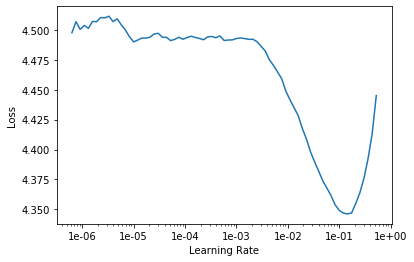

In [2]:

print(df.info())
np.random.seed(42)
lm_df = df.iloc[np.random.permutation(len(df))]
cut = int(0.2 * len(lm_df)) +1
train_lm_df, valid_lm_df = lm_df[cut:], lm_df[:cut]
data_lm = TextLMDataBunch.from_df(path, train_lm_df, valid_lm_df, text_cols=generator_text_cols,
                                  mark_fields=True,
                                  bs=bs)
data_lm.save(text_dir+'_data_lm.pkl')
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))
learn.save(text_dir+'_fit_head')
learn.load(text_dir+'_fit_head');
#to complete fine-tuning, unfreeze and launch a new training
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7)) #todo default 10
learn.save(text_dir+'_fine_tuned')
learn.load(text_dir+'_fine_tuned')

learn.export(file=Path(path/generator_learn_pkl_name))
learn.save_encoder(text_dir+'_fine_tuned_enc')



In [2]:
learn = load_learner(path,generator_learn_pkl_name)
#setup for text generation - prompts & number of words in each generated review
TOKENS = ["Hello world","xxbos","The court holds","Because","The court finds","Regarding count two", "Uncharted territory","who am i", "i was", "what"]
N_SENT = len(TOKENS)
N_WORDS = 100 
temp = 0.8


def predict(learn, text, n_words=1, temp=1., top1=False, min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Based on fastai implementation.
    For every word, gets the network activations, sets unknown token to 0,
    only considers tokens above a certain value, then either returns the token
    with the highest activation or samples from the distribution of activations.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        res = learn.pred_batch(batch=(xb,yb))[0][-1]
        res[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        res.pow_(1 / temp)
        if top1: idx = torch.argmax(res).item() # greedy decoding
        else: idx = torch.multinomial(res, 1).item()
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
    
def beam_search(learn, text, n_words=1, top_k=10, beam_sz=1000, temp=1., sep=' ', decoder=decode_spec_tokens):
    '''
    Based on fastai implementation.
    Performs beam search using provided parameters,
    returns either the sentence with the highest probability
    or samples from the distribution of probabilities.
    '''
    learn.model.reset()
    learn.model.eval()
    xb, yb = learn.data.one_item(text)
    nodes = None
    nodes = xb.clone()
    scores = xb.new_zeros(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(learn.model(xb)[0][:,-1], dim=-1)
            out[:,learn.data.vocab.stoi[UNK]] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                            indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            learn.model[0].select_hidden(indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    #print(scores)
    scores -= scores.max()
    node_idx = torch.multinomial(torch.exp(-scores / temp), 1).item()
    #node_idx = torch.argmax(scores) # returns top candidate instead of multinomial
    return '[' + text + ']' + sep + sep.join(decoder(
        learn.data.vocab.textify([i.item() for i in nodes[node_idx][2:]], sep=None)))
    
def predict_topk(learn, text, n_words=1, k=5, temp=1., min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Performs top-k sampling:
    selects the top-k probabilities, and then
    samples from their probability distribution and returns the token.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        outp = learn.pred_batch(batch=(xb,yb))[0][-1]
        outp[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: outp[outp < min_p] = 0.
        probs = F.softmax(outp / temp,dim=-1)
        vals,idxs = probs.topk(k, dim=-1)
        idx = idxs[torch.multinomial(vals, 1).item()]
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
    

def predict_nucleus(learn, text, n_words=1, p=0.5, temp=1., min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Performs top-p sampling:
    finds the k which corresponds to the desired cumulative
    probability, then performs top-k sampling as above.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        outp = learn.pred_batch(batch=(xb,yb))[0][-1]
        outp[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: outp[outp < min_p] = 0.
        probs = F.softmax(outp / temp, dim=-1) 
        cumsum_prob = (probs.sort(descending=True)[0]).cumsum(0)
        k = (cumsum_prob > p).nonzero().view(-1)[0].int() + 1
        vals,idxs = probs.topk(k, dim=-1)
        idx = idxs[torch.multinomial(vals, 1).item()]
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
#greedy top-1 prediction
print("\n\n".join(str(i+1) + ". " + predict(learn, TOKENS[i], N_WORDS, temp, True)
                  for i in range(N_SENT)))
#greedy multinomial prediction
print("\n\n".join(str(i+1) + ". " + predict(learn, TOKENS[i], N_WORDS, temp, False)
                  for i in range(N_SENT)))
#beam-search prediction
print("\n\n".join(str(i+1) + ". " + beam_search(learn, TOKENS[i], N_WORDS, top_k=6, beam_sz=20, temp=temp)
                  for i in range(N_SENT)))
#top-k prediction
print("\n\n".join(str(i+1) + ". " + predict_topk(learn, TOKENS[i], N_WORDS, 5, temp)
                  for i in range(N_SENT)))
#top-p prediction
print("\n\n".join(str(i+1) + ". " + predict_nucleus(learn, TOKENS[i], N_WORDS, p=1e-4, temp=temp)
                  for i in range(N_SENT)))

1. [Hello world] 
  No . UNITED STATES , AKA UNITED STATES , ET al.v . UNITED STATES . 
  No . 02 - 1011 . 
  Supreme Court of United States . 
  Argued March 3 , 2002 . 
  Decided June 1 , 2002 . 
  CERTIORARI TO THE UNITED STATES COURT OF APPEALS FOR THE NINTH CIRCUIT 
  * 1 * Scalia , J. , delivered the opinion

2. [xxbos] xxfld 1 
  127 S. Ct . ____ (((( 2007200720072007 )))) 
 
 
 
  Michael C. MOORE , Petitioner , 
  v. 
  John J. MOORE , Director , Texas Department of Criminal Justice , Institutional Division . 
  No . 06 - 4444 ____ .... 
 
 
 
  Supreme Court of United States . 
  Argued January 10 , 2007 . 
  Decided June 1 , 2007 . 
  * 
  David L.

3. [The court holds] that the United States has no right to sue for the recovery of damages for the breach of a contract . The United States is not a party to this suit . The United States is a party to the suit . The United States is a party to the suit . The United States is a party to the suit . The United States is a party to

1. [Hello world] 1 Xxunk world 
  No . 83 , Orig . 
  Supreme Court of United States . 
  October 4 , 1993 . 
 
  1 
  Appeal from the C. A. 9th Cir . 
 
 
  2 
  Certiorari denied . Reported below : 993 F.2d 794 . 
 
  xxbos xxfld 1 
  127 S. Ct . ____ (((( 2007200720072007 )))) 
 
 
 
  John F. DAVIS , Petitioner , 
  v. 
  UNITED STATES . 
  No . 06 -

2. [xxbos] 1 xxbos xxfld 1 
  103 U.S. 1 ( ____ )))) 
 
 
 
  UNITED STATES 
  v. 
  UNITED STATES . 
  Supreme Court of United States . 
 
  Mr. Assistant Attorney - General Smith for the United States . 
  Mr. Assistant Attorney - General Maury for the United States . 
  MR . CHIEF JUSTICE WAITE delivered the opinion of the court . 
  This is a bill in equity brought

3. [The court holds] 1 The court holds that the District Court had no jurisdiction over the case . 
  NOTES 
  [ * ] Briefs of amici curiae urging reversal were filed for the American Civil Liberties Union et al . by Daniel J. Popeo and Paul D. Kamenar ; and for the Na

In [ ]:
#Classifier
print('Classifier learning begin.')    
df = pd.read_csv(path/text_dir/csv_filename).fillna('')
data_clas = (TextList.from_df(df,path, cols=classifier_feature_cols, vocab=data_lm.vocab)
                   .split_by_rand_pct(.01)
                   .label_from_df(cols=classifier_label_cols)
                   .databunch(bs=bs))
data_clas.save(text_dir+'_data_clas.pkl')
data_clas = load_data(path, text_dir+'_data_clas.pkl', bs=bs)
data_clas.show_batch()
#creatae a model to classify those reviews and load the encoder we saved before
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(text_dir+'_fine_tuned_enc')
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1, 2e-2, moms=(.8, .7))
learn.save(text_dir+'_first')
learn.load(text_dir+'_first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save(text_dir+'_second')
learn.load(text_dir+'_second')
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save(text_dir+'_third')
learn.load(text_dir+'_third')
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.export(file=Path(path/classifier_learn_pkl_name))


In [3]:
#tmp cell to run third---DELETE AFTER RUN
data_clas = load_data(path, text_dir+'_data_clas.pkl', bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(text_dir+'_fine_tuned_enc')
learn.load(text_dir+'_third')
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.export(file=Path(path/classifier_learn_pkl_name))


epoch,train_loss,valid_loss,accuracy,time
0,1.028638,0.880124,0.788732,49:27


In [5]:
learn = load_learner(path,classifier_learn_pkl_name)
learn.predict("hold?")

(Category ,
 tensor(0),
 tensor([9.9062e-01, 6.5267e-06, 7.9139e-08, 2.9725e-07, 2.4812e-08, 1.8522e-08,
         4.2103e-08, 1.6577e-07, 4.3396e-08, 2.8847e-07, 2.4768e-07, 2.1313e-08,
         1.2602e-04, 4.7616e-05, 6.5557e-05, 7.0585e-05, 5.6956e-07, 6.4284e-05,
         3.7282e-08, 3.5654e-06, 6.6178e-07, 1.1703e-05, 2.3238e-07, 2.9911e-06,
         1.5226e-07, 8.1621e-07, 2.3535e-07, 3.7351e-06, 1.9331e-05, 2.2025e-07,
         1.2752e-07, 7.3245e-08, 4.3647e-06, 2.5589e-07, 3.5478e-06, 8.1303e-08,
         2.0381e-08, 3.4943e-06, 1.2484e-08, 2.8922e-07, 4.5120e-06, 1.0416e-04,
         2.2854e-07, 5.7815e-07, 9.5728e-05, 5.4198e-06, 6.0886e-05, 8.7565e-08,
         1.8675e-07, 1.5592e-05, 1.0239e-07, 1.9771e-06, 1.9793e-07, 1.2106e-07,
         4.8391e-06, 1.3913e-05, 3.3870e-07, 1.8272e-06, 2.5651e-07, 1.4788e-05,
         4.5145e-06, 3.2759e-08, 1.8287e-05, 1.0446e-07, 1.2958e-06, 8.4317e-06,
         4.7374e-06, 5.0635e-06, 2.1116e-06, 1.1123e-07, 1.3826e-05, 6.7951e-07,
    